# Context
credit score cards are a common risk control method in the financial industry. It uses personal information and data submitted by credit card applicants to predict the probability of future defaults and credit card borrowings. The bank is able to decide whether to issue a credit card to the applicant. Credit scores can objectively quantify the magnitude of risk.
 
Generally speaking, credit score cards are based on historical data. Once encountering large economic fluctuations. Past models may lose their original predictive power. Logistic model is a common method for credit scoring. Because Logistic is suitable for binary classification tasks and can calculate the coefficients of each feature. In order to facilitate understanding and operation, the score card will multiply the logistic regression coefficient by a certain value (such as 100) and round it.
 
At present, with the development of machine learning algorithms. More predictive methods such as Boosting, Random Forest, and Support Vector Machines have been introduced into credit card scoring. However, these methods often do not have good transparency. It may be difficult to provide customers and regulators with a reason for rejection or acceptance.

# Task
Build a machine learning model to predict if an applicant is 'good' or 'bad' client, different from other tasks, the definition of 'good' or 'bad' is not given. You should use some techique, such as vintage analysis to construct you label. Also, unbalance data problem is a big problem in this task.

# Content & Explanation
There're two tables could be merged by ID:

## application_record.csv		
    Feature name	Explanation	Remarks
    ID	Client number	
    CODE_GENDER	Gender	
    FLAG_OWN_CAR	Is there a car	
    FLAG_OWN_REALTY	Is there a property	
    CNT_CHILDREN	Number of children	
    AMT_INCOME_TOTAL	Annual income	
    NAME_INCOME_TYPE	Income category	
    NAME_EDUCATION_TYPE	Education level	
    NAME_FAMILY_STATUS	Marital status	
    NAME_HOUSING_TYPE	Way of living	
    DAYS_BIRTH	Birthday	Count backwards from current day (0), -1 means yesterday
    DAYS_EMPLOYED	Start date of employment	Count backwards from current day(0). If positive, it means the person currently unemployed.
    FLAG_MOBIL	Is there a mobile phone	
    FLAG_WORK_PHONE	Is there a work phone	
    FLAG_PHONE	Is there a phone	
    FLAG_EMAIL	Is there an email	
    OCCUPATION_TYPE	Occupation	
    CNT_FAM_MEMBERS	Family size	

## cred_rcrd.csv		
    Feature name	Explanation	Remarks
    ID	Client number	
    MONTHS_BALANCE	Record month	The month of the extracted data is the starting point, backwards, 0 is the current month, -1 is the previous month, and so on
    STATUS	Status	0: 1-29 days past due 1: 30-59 days past due 2: 60-89 days overdue 3: 90-119 days overdue 4: 120-149 days overdue 5: Overdue or bad debts, write-offs for more than 150 days C: paid off that month X: No loan for the month

In [ ]:
# data pre-processing
import os
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import numpy as np

# Visualization libraries
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# statistical libraries
import scipy.stats as stats

# Machine learning
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier



# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [454]:
# Load the two datasets
application = pd.read_csv('application_record.csv')
credit = pd.read_csv('credit_record.csv')

print("Shape of the datasets:")
print(application.shape)
print(credit.shape)  

print("\nInfo and first few rows of application:")
print(application.info())
print(application.head())

print("\nInfo and first few rows of credit:")
print(credit.info())
print(credit.head())

Shape of the datasets:
(438557, 18)
(1048575, 3)

Info and first few rows of application:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 n

In [455]:
# common ids between application and credit record
len(set(application['ID']).intersection(set(credit['ID'])))

36457

vintage analysis (code borrowed from: https://www.kaggle.com/code/rikdifos/eda-vintage-analysis)

In [456]:
# we need to decide who is the bad customer from credit record and also how much data do we need to make this decision
grouped = credit.groupby('ID')

### convert credit data to wide format which every id is a row and each value from Months_balance is a column
pivot_tb = credit.pivot(index = 'ID', columns = 'MONTHS_BALANCE', values = 'STATUS')

In [457]:
pivot_tb

MONTHS_BALANCE,-60,-59,-58,-57,-56,-55,-54,-53,-52,-51,...,-9,-8,-7,-6,-5,-4,-3,-2,-1,0
ID,,,,,,,,,,,,,,,,,,,,,
5001711,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,X
5001712,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,C,C,C,C,C,C,C,C,C
5001713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,X,X,X,X,X,X,X,X,X,X
5001714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,X,X,X,X,X,X,X,X,X,X
5001715,NaN,X,X,X,X,X,X,X,X,X,...,X,X,X,X,X,X,X,X,X,X
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5150482,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5150483,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,X,X,X,X,X,X,X,X,X,X
5150484,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,0,C


In [458]:
# derive open month and end month for every customer
pivot_tb['open_month'] = grouped['MONTHS_BALANCE'].min() # smallest value of MONTHS_BALANCE, first observation month
pivot_tb['end_month'] = grouped['MONTHS_BALANCE'].max() # biggest value of MONTHS_BALANCE, last observation month
pivot_tb['ID'] = pivot_tb.index
pivot_tb = pivot_tb[['ID', 'open_month', 'end_month']]

# calculate observation window which we later use to determine how much observation data we need to make a decision (good or bad customer)
pivot_tb['window'] = pivot_tb['end_month'] - pivot_tb['open_month']
pivot_tb.reset_index(drop = True, inplace = True)

In [459]:
pivot_tb.head()

MONTHS_BALANCE,ID,open_month,end_month,window
0,5001711,-3,0,3
1,5001712,-18,0,18
2,5001713,-21,0,21
3,5001714,-14,0,14
4,5001715,-59,0,59


In [460]:
# join calculated information back to credit record
credit = pd.merge(credit, pivot_tb, on = 'ID', how = 'left') # join calculated information
credit0 = credit.copy()

In [461]:
credit.head()

,ID,MONTHS_BALANCE,STATUS,open_month,end_month,window
0,5001711,0,X,-3,0,3
1,5001711,-1,0,-3,0,3
2,5001711,-2,0,-3,0,3
3,5001711,-3,0,-3,0,3
4,5001712,0,C,-18,0,18


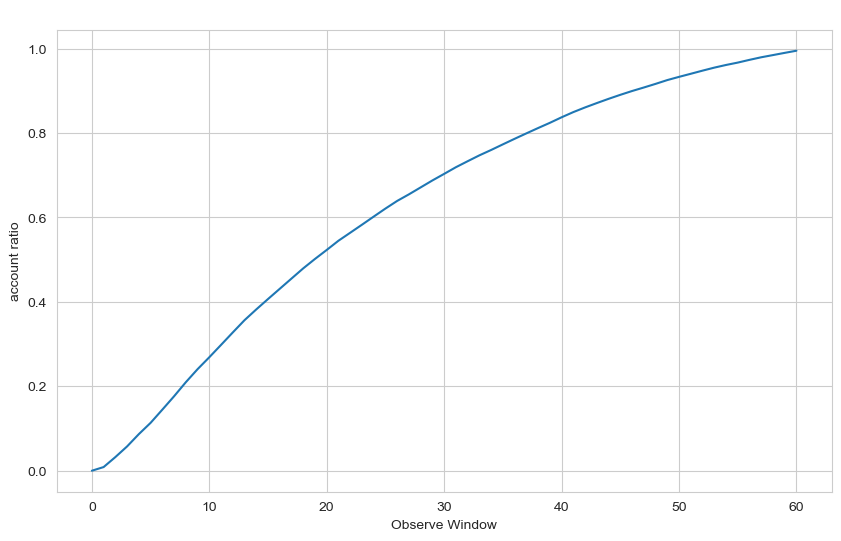

In [462]:
lst = []
for i in range(0,61):
    ratio = len(pivot_tb[pivot_tb['window'] < i]) / len(set(pivot_tb['ID']))
    lst.append(ratio)
    
pd.Series(lst).plot(legend = False, grid = True, title = ' ')
plt.xlabel('Observe Window')
plt.ylabel('account ratio')
plt.show()

In [463]:
def calculate_rate(pivot_tb, command): 
    '''calculate bad customer rate
    '''
    credit0['status'] = None
    exec(command) # excuate input code
    sumagg = credit0.groupby('ID')['status'].agg(sum)
    pivot_tb = pd.merge(pivot_tb, sumagg, on = 'ID', how = 'left')
    pivot_tb.loc[pivot_tb['status'] > 1, 'status'] = 1
    rate = pivot_tb['status'].sum() / len(pivot_tb)
    return round(rate, 5)

command = "credit0.loc[(credit0['STATUS'] == '0') | (credit0['STATUS'] == '1') | (credit0['STATUS'] == '2') | (credit0['STATUS'] == '3' )| (credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"   
morethan1 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '1') | (credit0['STATUS'] == '2') | (credit0['STATUS'] == '3' )| (credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"   
morethan30 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '2') | (credit0['STATUS'] == '3' )| (credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"
morethan60 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '3' )| (credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"
morethan90 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"
morethan120 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '5'), 'status'] = 1"
morethan150 = calculate_rate(pivot_tb, command)

summary_dt = pd.DataFrame({'situation':['past due more than 1 day',
                               'past due more than 30 days',
                               'past due more than 60 days',
                               'past due more than 90 days',
                               'past due more than 120 days',
                               'past due more than 150 days'],
                      'bad customer ratio':[morethan1,
                               morethan30,
                               morethan60,
                               morethan90, 
                               morethan120,
                               morethan150, 
                      ]})
summary_dt

,situation,bad customer ratio
0,past due more than 1 day,0.87
1,past due more than 30 days,0.12
2,past due more than 60 days,0.01
3,past due more than 90 days,0.01
4,past due more than 120 days,0.01
5,past due more than 150 days,0.00


In [464]:
def calculate_observe(credit, command):
    '''calculate observe window
    '''
    id_sum = len(set(pivot_tb['ID']))
    credit['status'] = 0
    exec(command)
    #credit.loc[(credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1
    credit['month_on_book'] = credit['MONTHS_BALANCE'] - credit['open_month']
    minagg = credit[credit['status'] == 1].groupby('ID')['month_on_book'].min()
    minagg = pd.DataFrame(minagg)
    minagg['ID'] = minagg.index
    obslst = pd.DataFrame({'month_on_book':range(0,61), 'rate': None})
    lst = []
    for i in range(0,61):
        due = list(minagg[minagg['month_on_book']  == i]['ID'])
        lst.extend(due)
        obslst.loc[obslst['month_on_book'] == i, 'rate'] = len(set(lst)) / id_sum 
    return obslst['rate']

command = "credit.loc[(credit['STATUS'] == '0') | (credit['STATUS'] == '1') | (credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"   
morethan1 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '1') | (credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"   
morethan30 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"
morethan60 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"
morethan90 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"
morethan120 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '5'), 'status'] = 1"
morethan150 = calculate_observe(credit, command)

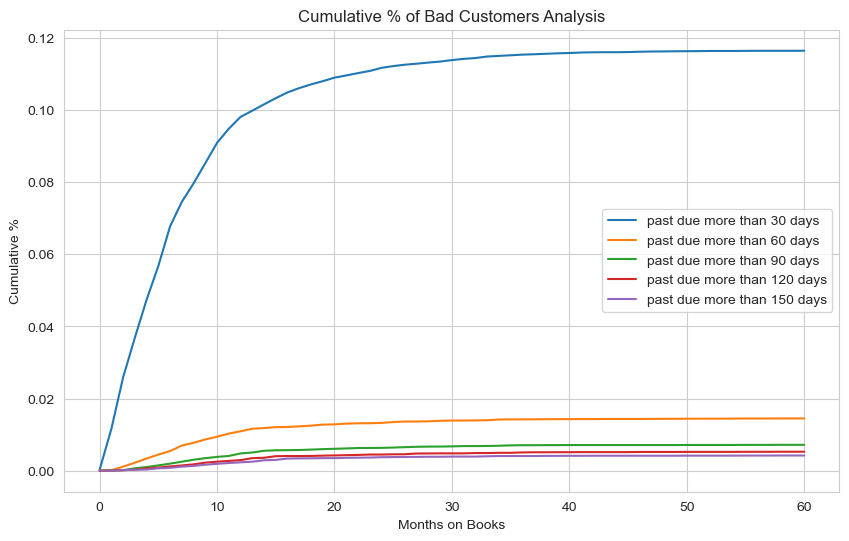

In [465]:
obslst = pd.DataFrame({'past due more than 30 days': morethan30,
                       'past due more than 60 days': morethan60,
                       'past due more than 90 days': morethan90,
                       'past due more than 120 days': morethan120,
                       'past due more than 150 days': morethan150
                        })

obslst.plot(grid = True, title = 'Cumulative % of Bad Customers Analysis')
plt.xlabel('Months on Books')
plt.ylabel('Cumulative %')
plt.show()

In [466]:
# delete users whose observation window is less than 20 months
credit = credit[credit['window'] > 20] 
credit['status'] = np.where((credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 1, 0) # analyze > 60 days past due 
credit['status'] = credit['status'].astype(np.int8) # 1: overdue 0: not
credit['month_on_book'] = credit['MONTHS_BALANCE'] - credit['open_month'] # calculate month on book: how many months after opening account
credit.sort_values(by = ['ID','month_on_book'], inplace = True)

In [467]:
credit.head()

,ID,MONTHS_BALANCE,STATUS,open_month,end_month,window,status,month_on_book
44,5001713,-21,X,-21,0,21,0,0
43,5001713,-20,X,-21,0,21,0,1
42,5001713,-19,X,-21,0,21,0,2
41,5001713,-18,X,-21,0,21,0,3
40,5001713,-17,X,-21,0,21,0,4


In [468]:
##### denominator
denominator = pivot_tb.groupby(['open_month']).agg({'ID': ['count']}) # count how many users in every month the account was opened
denominator.reset_index(inplace = True)
denominator.columns = ['open_month','sta_sum'] # status sum

##### ventage table
vintage = credit.groupby(['open_month','month_on_book']).agg({'ID': ['count']}) 
vintage.reset_index(inplace = True)
vintage.columns = ['open_month','month_on_book','sta_sum'] 
vintage['due_count'] = np.nan
vintage = vintage[['open_month','month_on_book','due_count']] # delete aggerate column
vintage = pd.merge(vintage, denominator, on = ['open_month'], how = 'left') # join sta_sum colun to vintage table
vintage

,open_month,month_on_book,due_count,sta_sum
0,-60,0,NaN,415
1,-60,1,NaN,415
2,-60,2,NaN,415
3,-60,3,NaN,415
4,-60,4,NaN,415
...,...,...,...,...
1655,-21,17,NaN,858
1656,-21,18,NaN,858
1657,-21,19,NaN,858
1658,-21,20,NaN,858


In [469]:
for j in range(-60,1): # outer loop: month in which account was opened
    ls = []
    for i in range(0,61): # inner loop time after the credit card was granted
        due = list(credit[(credit['status'] == 1) & (credit['month_on_book'] == i) & (credit['open_month'] == j)]['ID']) # get ID which satisfy the condition
        ls.extend(due) # As time goes, add bad customers
        vintage.loc[(vintage['month_on_book'] == i) & (vintage['open_month'] == j), 'due_count'] = len(set(ls)) # calculate non-duplicate ID numbers using set()
        
vintage['sta_rate']  = vintage['due_count'] / vintage['sta_sum'] # calculate cumulative % of bad customers
vintage    

,open_month,month_on_book,due_count,sta_sum,sta_rate
0,-60,0,0.00,415,0.00
1,-60,1,0.00,415,0.00
2,-60,2,0.00,415,0.00
3,-60,3,0.00,415,0.00
4,-60,4,0.00,415,0.00
...,...,...,...,...,...
1655,-21,17,15.00,858,0.02
1656,-21,18,15.00,858,0.02
1657,-21,19,15.00,858,0.02
1658,-21,20,15.00,858,0.02


In [470]:
### Vintage wide table
vintage_wide = vintage.pivot(index = 'open_month',
                             columns = 'month_on_book',
                             values = 'sta_rate')
# vintage_wide

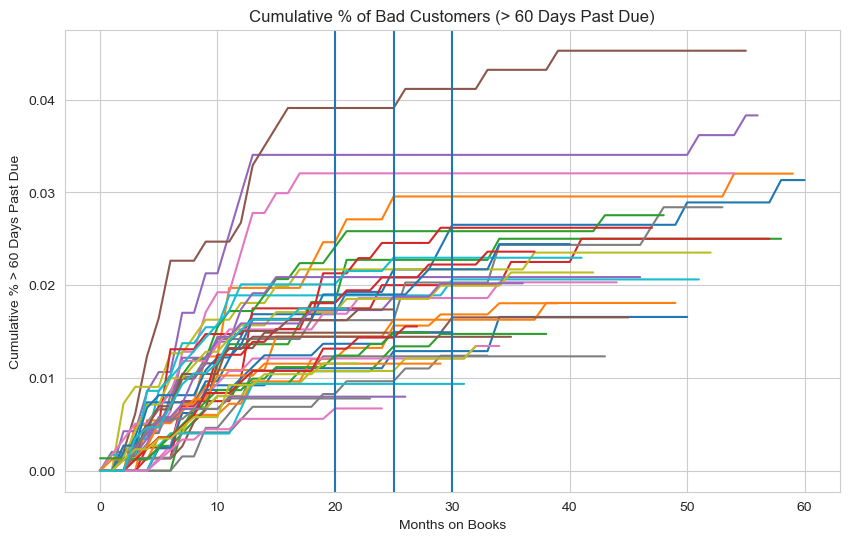

In [471]:
# plot vintage line chart
plt.rcParams['figure.facecolor'] = 'white'
vintage0 = vintage_wide.replace(0,np.nan)
lst = [i for i in range(0,61)]
vintage_wide[lst].T.plot(legend = False, grid = True, title = 'Cumulative % of Bad Customers (> 60 Days Past Due)')
plt.axvline(30)
plt.axvline(25)
plt.axvline(20)
plt.xlabel('Months on Books')
plt.ylabel('Cumulative % > 60 Days Past Due')
plt.show()

In [472]:
print(credit)

              ID  MONTHS_BALANCE STATUS  open_month  end_month  window  \
44       5001713             -21      X         -21          0      21   
43       5001713             -20      X         -21          0      21   
42       5001713             -19      X         -21          0      21   
41       5001713             -18      X         -21          0      21   
40       5001713             -17      X         -21          0      21   
...          ...             ...    ...         ...        ...     ...   
1048549  5150487              -4      C         -29          0      29   
1048548  5150487              -3      C         -29          0      29   
1048547  5150487              -2      C         -29          0      29   
1048546  5150487              -1      C         -29          0      29   
1048545  5150487               0      C         -29          0      29   

         status  month_on_book  
44            0              0  
43            0              1  
42          

Create the label column and join the two dataframes

In [473]:
# total unique customers after filtering out those with observation window less than 20 months
print(f"Total unique customers: {credit['ID'].nunique():,}")

Total unique customers: 20,924


In [474]:
# Filter for first 20 months only
credit_first20 = credit[credit['month_on_book'] <= 20]

In [475]:
# Create labels: bad if any status=1 in first 20 months
labels = credit_first20.groupby('ID')['status'].max().reset_index()
labels.columns = ['ID', 'label']

In [476]:
labels

,ID,label
0,5001713,0
1,5001715,0
2,5001717,0
3,5001718,0
4,5001719,0
...,...,...
20919,5150475,0
20920,5150476,0
20921,5150480,0
20922,5150481,0


In [477]:
# Merge with application data (common column = ID)
df = pd.merge(application, labels, on='ID', how='inner')

In [478]:
df

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,label
0,5008806,M,Y,Y,0,112500.00,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.00,0
1,5008810,F,N,Y,0,270000.00,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.00,0
2,5008811,F,N,Y,0,270000.00,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.00,0
3,5112956,M,Y,Y,0,270000.00,Working,Higher education,Married,House / apartment,-16872,-769,1,1,1,1,Accountants,2.00,0
4,5008825,F,Y,N,0,130500.00,Working,Incomplete higher,Married,House / apartment,-10669,-1103,1,0,0,0,Accountants,2.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15161,5149145,M,Y,Y,0,247500.00,Working,Secondary / secondary special,Married,House / apartment,-10952,-3577,1,1,0,0,Laborers,2.00,1
15162,5149158,M,Y,Y,0,247500.00,Working,Secondary / secondary special,Married,House / apartment,-10952,-3577,1,1,0,0,Laborers,2.00,1
15163,5149729,M,Y,Y,0,90000.00,Working,Secondary / secondary special,Married,House / apartment,-19101,-1721,1,0,0,0,NaN,2.00,1
15164,5149834,F,N,Y,0,157500.00,Commercial associate,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2.00,1


In [479]:
# Check distribution
print(f"Labeled customers: {len(df):,}")
print(f"Bad rate: {df['label'].mean():.2%}")
print(f"Good: {len(df[df['label']==0]):,}")
print(f"Bad: {len(df[df['label']==1]):,}")

Labeled customers: 15,166
Bad rate: 2.47%
Good: 14,791
Bad: 375


As we can see there is a class imbalance between the two classes we have

# EDA and Feature engineering

In [480]:
df.head(10)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,label
0,5008806,M,Y,Y,0,112500.00,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.00,0
1,5008810,F,N,Y,0,270000.00,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.00,0
2,5008811,F,N,Y,0,270000.00,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.00,0
3,5112956,M,Y,Y,0,270000.00,Working,Higher education,Married,House / apartment,-16872,-769,1,1,1,1,Accountants,2.00,0
4,5008825,F,Y,N,0,130500.00,Working,Incomplete higher,Married,House / apartment,-10669,-1103,1,0,0,0,Accountants,2.00,0
5,5008826,F,Y,N,0,130500.00,Working,Incomplete higher,Married,House / apartment,-10669,-1103,1,0,0,0,Accountants,2.00,0
6,5008830,F,N,Y,0,157500.00,Working,Secondary / secondary special,Married,House / apartment,-10031,-1469,1,0,1,0,Laborers,2.00,0
7,5008832,F,N,Y,0,157500.00,Working,Secondary / secondary special,Married,House / apartment,-10031,-1469,1,0,1,0,Laborers,2.00,0
8,5008834,F,N,Y,1,112500.00,Working,Secondary / secondary special,Single / not married,House / apartment,-10968,-1620,1,0,0,0,NaN,2.00,0
9,5008838,M,N,Y,1,405000.00,Commercial associate,Higher education,Married,House / apartment,-11842,-2016,1,0,0,0,Managers,3.00,0


In [481]:
# Basic info
print(df.shape)
print(df.dtypes)
print(df.isnull().sum())

(15166, 19)
ID                       int64
CODE_GENDER             object
FLAG_OWN_CAR            object
FLAG_OWN_REALTY         object
CNT_CHILDREN             int64
AMT_INCOME_TOTAL       float64
NAME_INCOME_TYPE        object
NAME_EDUCATION_TYPE     object
NAME_FAMILY_STATUS      object
NAME_HOUSING_TYPE       object
DAYS_BIRTH               int64
DAYS_EMPLOYED            int64
FLAG_MOBIL               int64
FLAG_WORK_PHONE          int64
FLAG_PHONE               int64
FLAG_EMAIL               int64
OCCUPATION_TYPE         object
CNT_FAM_MEMBERS        float64
label                     int8
dtype: object
ID                        0
CODE_GENDER               0
FLAG_OWN_CAR              0
FLAG_OWN_REALTY           0
CNT_CHILDREN              0
AMT_INCOME_TOTAL          0
NAME_INCOME_TYPE          0
NAME_EDUCATION_TYPE       0
NAME_FAMILY_STATUS        0
NAME_HOUSING_TYPE         0
DAYS_BIRTH                0
DAYS_EMPLOYED             0
FLAG_MOBIL                0
FLAG_WORK_PHONE      

In [482]:
# Categorical values
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
cat_cols

['CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE']

In [483]:
for col in cat_cols:
    print(f"\n{col.upper()}:")
    print(f"Unique values: {df[col].unique()}")
    print(f"counts:")
    print(df[col].value_counts())
    print(f"Percentage distribution:")
    print((df[col].value_counts(normalize=True) * 100).round(2))


CODE_GENDER:
Unique values: ['M' 'F']
counts:
CODE_GENDER
F    10081
M     5085
Name: count, dtype: int64
Percentage distribution:
CODE_GENDER
F   66.47
M   33.53
Name: proportion, dtype: float64

FLAG_OWN_CAR:
Unique values: ['Y' 'N']
counts:
FLAG_OWN_CAR
N    9138
Y    6028
Name: count, dtype: int64
Percentage distribution:
FLAG_OWN_CAR
N   60.25
Y   39.75
Name: proportion, dtype: float64

FLAG_OWN_REALTY:
Unique values: ['Y' 'N']
counts:
FLAG_OWN_REALTY
Y    9900
N    5266
Name: count, dtype: int64
Percentage distribution:
FLAG_OWN_REALTY
Y   65.28
N   34.72
Name: proportion, dtype: float64

NAME_INCOME_TYPE:
Unique values: ['Working' 'Commercial associate' 'State servant' 'Pensioner' 'Student']
counts:
NAME_INCOME_TYPE
Working                 7753
Commercial associate    3613
Pensioner               2473
State servant           1319
Student                    8
Name: count, dtype: int64
Percentage distribution:
NAME_INCOME_TYPE
Working                51.12
Commercial associate   2

Gender

In [484]:
df = df.rename(columns={'CODE_GENDER': 'sex'})

In [485]:
# Just see default rates by sex
risk = df.groupby('sex')['label'].mean()
print(f"Default rate by sex:\n{risk}")

Default rate by sex:
sex
F   0.02
M   0.03
Name: label, dtype: float64


In [486]:
df['is_male'] = (df['sex'] == 'M').astype(int)
df = df.drop(columns=['sex'])

In [487]:
df.head()

,ID,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,label,is_male
0,5008806,Y,Y,0,112500.00,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.00,0,1
1,5008810,N,Y,0,270000.00,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.00,0,0
2,5008811,N,Y,0,270000.00,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.00,0,0
3,5112956,Y,Y,0,270000.00,Working,Higher education,Married,House / apartment,-16872,-769,1,1,1,1,Accountants,2.00,0,1
4,5008825,Y,N,0,130500.00,Working,Incomplete higher,Married,House / apartment,-10669,-1103,1,0,0,0,Accountants,2.00,0,0


Car

In [488]:
df = df.rename(columns={'FLAG_OWN_CAR': 'has_car'})
print(df['has_car'].value_counts(normalize=True))
car_risk = df.groupby('has_car')['label'].mean()
print(f"Default rate by car ownership:\n{car_risk}")

has_car
N   0.60
Y   0.40
Name: proportion, dtype: float64
Default rate by car ownership:
has_car
N   0.03
Y   0.02
Name: label, dtype: float64


In [489]:
df['has_car'] = (df['has_car'] == 'Y').astype(int)
df.head(2)

,ID,has_car,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,label,is_male
0,5008806,1,Y,0,112500.00,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.00,0,1
1,5008810,0,Y,0,270000.00,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.00,0,0


Realty (Property)

In [490]:
# Rename
df = df.rename(columns={'FLAG_OWN_REALTY': 'has_property'})
print(df['has_property'].value_counts(normalize=True))
prop_risk = df.groupby('has_property')['label'].mean()
print(f"\nDefault rates:\n{prop_risk}")

has_property
Y   0.65
N   0.35
Name: proportion, dtype: float64

Default rates:
has_property
N   0.03
Y   0.02
Name: label, dtype: float64


In [491]:
# Binary encoding
df['has_property'] = (df['has_property'] == 'Y').astype(int)
df.head(2)

,ID,has_car,has_property,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,label,is_male
0,5008806,1,1,0,112500.00,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.00,0,1
1,5008810,0,1,0,270000.00,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.00,0,0


Income typoe

In [492]:
# Rename
df = df.rename(columns={'NAME_INCOME_TYPE': 'income_type'})

# Check distribution
print(df['income_type'].value_counts(normalize=True).round(3))

# Risk analysis
inc_risk = df.groupby('income_type')['label'].mean().sort_values()
print(f"\nDefault rates by income type:\n{inc_risk}")

income_type
Working                0.51
Commercial associate   0.24
Pensioner              0.16
State servant          0.09
Student                0.00
Name: proportion, dtype: float64

Default rates by income type:
income_type
Student                0.00
State servant          0.01
Commercial associate   0.02
Working                0.02
Pensioner              0.03
Name: label, dtype: float64


There is an ordinal relation, so going with Risk-weighted ordinal encoding

In [493]:
# Risk-weighted ordinal encoding
risk_map = {
    'Student': 1, 
    'State servant': 2, 
    'Commercial associate': 3,
    'Working': 4, 
    'Pensioner': 5
    }
df['inc_type_enc'] = df['income_type'].map(risk_map)
df = df.drop(columns=['income_type'])
print(df.groupby('inc_type_enc')['label'].mean()) # verifying

inc_type_enc
1   0.00
2   0.01
3   0.02
4   0.02
5   0.03
Name: label, dtype: float64


Education

In [494]:
# Rename
df = df.rename(columns={'NAME_EDUCATION_TYPE': 'education'})

# Distribution and risk
print(df['education'].value_counts(normalize=True))
print(df.groupby('education')['label'].mean().sort_values())

education
Secondary / secondary special   0.67
Higher education                0.28
Incomplete higher               0.04
Lower secondary                 0.01
Academic degree                 0.00
Name: proportion, dtype: float64
education
Academic degree                 0.00
Higher education                0.02
Secondary / secondary special   0.03
Incomplete higher               0.03
Lower secondary                 0.05
Name: label, dtype: float64


In [495]:
# Map based on risk level same as above
edu_map = {
    'Academic degree': 1,               # Lowest risk
    'Higher education': 2,
    'Secondary / secondary special': 3,
    'Incomplete higher': 4,
    'Lower secondary': 5                # Highest risk
}
df['edu_enc'] = df['education'].map(edu_map)
df = df.drop(columns=['education'])
print(df.groupby('edu_enc')['label'].mean())

edu_enc
1   0.00
2   0.02
3   0.03
4   0.03
5   0.05
Name: label, dtype: float64


Family status

In [496]:
# Rename
df = df.rename(columns={'NAME_FAMILY_STATUS': 'family_status'})

# Distribution and risk
print(df['family_status'].value_counts(normalize=True))
print(df.groupby('family_status')['label'].mean().sort_values())

family_status
Married                0.71
Single / not married   0.12
Civil marriage         0.07
Separated              0.06
Widow                  0.04
Name: proportion, dtype: float64
family_status
Separated              0.02
Married                0.02
Civil marriage         0.03
Single / not married   0.04
Widow                  0.06
Name: label, dtype: float64


In [497]:
status_map = {
    'Separated': 1,
    'Married': 2,
    'Civil marriage': 3,
    'Single / not married': 4,
    'Widow': 5
}

df['family_enc'] = df['family_status'].map(status_map)
df = df.drop(columns=['family_status'])
print(df.groupby('family_enc')['label'].mean())

family_enc
1   0.02
2   0.02
3   0.03
4   0.04
5   0.06
Name: label, dtype: float64


Housing

In [498]:
df = df.rename(columns={'NAME_HOUSING_TYPE': 'housing'})
print(df['housing'].value_counts(normalize=True))
print(df.groupby('housing')['label'].mean().sort_values())

housing
House / apartment     0.90
With parents          0.04
Municipal apartment   0.03
Rented apartment      0.01
Office apartment      0.01
Co-op apartment       0.01
Name: proportion, dtype: float64
housing
With parents          0.02
House / apartment     0.02
Rented apartment      0.03
Co-op apartment       0.03
Municipal apartment   0.04
Office apartment      0.06
Name: label, dtype: float64


In [499]:
# flagging only HIGH RISK 
df['housing_municipal'] = (df['housing'] == 'Municipal apartment').astype(int)
df['housing_office'] = (df['housing'] == 'Office apartment').astype(int)
df = df.drop(columns=['housing'])

Occupation

In [500]:
df.columns

Index(['ID', 'has_car', 'has_property', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL',
       'DAYS_BIRTH', 'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS',
       'label', 'is_male', 'inc_type_enc', 'edu_enc', 'family_enc',
       'housing_municipal', 'housing_office'],
      dtype='object')

In [501]:
# Handle missing
df = df.rename(columns={'OCCUPATION_TYPE': 'occupation'})
df['occupation'] = df['occupation'].fillna('Unknown')

# Check distribution
occ_counts = df['occupation'].value_counts()
print(f"Unique occupations: {len(occ_counts)}")
print(f"Top 10 occupations:\n{occ_counts.head(10)}")
print(f"\nBottom 10 occupations:\n{occ_counts.tail(10)}")
print(df['occupation'].value_counts(normalize=True))
print(df.groupby('occupation')['label'].mean().sort_values())

Unique occupations: 19
Top 10 occupations:
occupation
Unknown                  4654
Laborers                 2557
Core staff               1517
Sales staff              1359
Managers                 1338
Drivers                   955
High skill tech staff     659
Medicine staff            550
Accountants               503
Cooking staff             259
Name: count, dtype: int64

Bottom 10 occupations:
occupation
Cooking staff            259
Security staff           232
Cleaning staff           213
Private service staff    120
Low-skill Laborers        64
Secretaries               63
Waiters/barmen staff      49
HR staff                  30
IT staff                  27
Realty agents             17
Name: count, dtype: int64
occupation
Unknown                 0.31
Laborers                0.17
Core staff              0.10
Sales staff             0.09
Managers                0.09
Drivers                 0.06
High skill tech staff   0.04
Medicine staff          0.04
Accountants             0.

In [502]:
def tier_occupation(occ):
    # High risk
    if occ in ['Low-skill Laborers', 'Security staff', 'Drivers', 'HR staff', 'High skill tech staff']:
        return 3
    # Medium risk  
    elif occ in ['Accountants', 'Laborers', 'Core staff', 'Sales staff', 'Unknown', 'Waiters/barmen staff']:
        return 2
    # Low risk
    else:
        return 1

df['occ_tier'] = df['occupation'].apply(tier_occupation)
df = df.drop(columns=['occupation'])

In [503]:
# Verify tier distribution
print(f"Tier distribution: {df['occ_tier'].value_counts(normalize=True)}")
print(f"Tier risk distribution: {df.groupby('occ_tier')['label'].mean()}")

Tier distribution: occ_tier
2   0.70
1   0.17
3   0.13
Name: proportion, dtype: float64
Tier risk distribution: occ_tier
1   0.01
2   0.03
3   0.04
Name: label, dtype: float64


NUmerical columns

In [504]:
# numerical columns
num_cols = [col for col in df.columns if col.isupper()]
num_cols

['ID',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'FLAG_MOBIL',
 'FLAG_WORK_PHONE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'CNT_FAM_MEMBERS']

Number of chilkdren

In [505]:
df = df.rename(columns={'CNT_CHILDREN': 'children'})
print(df['children'].value_counts().sort_index())
print(df.groupby('children')['label'].mean())

children
0     10516
1      3030
2      1398
3       188
4        23
5         7
7         2
14        2
Name: count, dtype: int64
children
0    0.03
1    0.02
2    0.02
3    0.04
4    0.04
5    0.00
7    0.00
14   0.00
Name: label, dtype: float64


In [506]:
df = df[df['children'] <= 4]

In [507]:
# Create children flags
df['has_children'] = (df['children'] > 0).astype(int)
df['has_3plus_children'] = (df['children'] >= 3).astype(int)

print(f"Has children: {df['has_children'].mean():.1%}")
print(f"3+ children: {df['has_3plus_children'].mean():.1%}")

print(f"No children: {df[df['has_children']==0]['label'].mean():.3%}")
print(f"Has children: {df[df['has_children']==1]['label'].mean():.3%}")
print(f"3+ children: {df[df['has_3plus_children']==1]['label'].mean():.3%}")

Has children: 30.6%
3+ children: 1.4%
No children: 2.577%
Has children: 2.242%
3+ children: 4.265%


Income amount

In [508]:
print(df[['AMT_INCOME_TOTAL']].describe())

       AMT_INCOME_TOTAL
count          15155.00
mean          189270.20
std           102002.12
min            27000.00
25%           126000.00
50%           166500.00
75%           225000.00
max          1575000.00


In [509]:
df = df.rename(columns={'AMT_INCOME_TOTAL': 'inc_amt'})
df['inc_group'] = pd.qcut(df['inc_amt'], 10)
print(df.groupby('inc_group')['label'].mean())

inc_group
(26999.999, 90000.0]    0.03
(90000.0, 112500.0]     0.03
(112500.0, 135000.0]    0.03
(135000.0, 144000.0]    0.00
(144000.0, 166500.0]    0.02
(166500.0, 180000.0]    0.03
(180000.0, 225000.0]    0.03
(225000.0, 247500.0]    0.02
(247500.0, 315000.0]    0.02
(315000.0, 1575000.0]   0.01
Name: label, dtype: float64


In [510]:
df.head()

,ID,has_car,has_property,children,inc_amt,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,...,is_male,inc_type_enc,edu_enc,family_enc,housing_municipal,housing_office,occ_tier,has_children,has_3plus_children,inc_group
0,5008806,1,1,0,112500.00,-21474,-1134,1,0,0,...,1,4,3,2,0,0,3,0,0,"(90000.0, 112500.0]"
1,5008810,0,1,0,270000.00,-19110,-3051,1,0,1,...,0,3,3,4,0,0,2,0,0,"(247500.0, 315000.0]"
2,5008811,0,1,0,270000.00,-19110,-3051,1,0,1,...,0,3,3,4,0,0,2,0,0,"(247500.0, 315000.0]"
3,5112956,1,1,0,270000.00,-16872,-769,1,1,1,...,1,4,2,2,0,0,2,0,0,"(247500.0, 315000.0]"
4,5008825,1,0,0,130500.00,-10669,-1103,1,0,0,...,0,4,4,2,0,0,2,0,0,"(112500.0, 135000.0]"


In [511]:
df = df.drop(columns=['inc_group'])

Age

In [512]:
df['age'] = -df['DAYS_BIRTH'] / 365.25
print(f"Age: {df['age'].min():.0f} to {df['age'].max():.0f} years")

# Quick risk check
df['age_group'] = (df['age'] // 5) * 5
print(df.groupby('age_group').agg({'label':'mean', 'age':'count'}))

Age: 22 to 69 years
           label   age
age_group             
20.00       0.04   139
25.00       0.03  1522
30.00       0.03  2103
35.00       0.02  2277
40.00       0.02  2294
45.00       0.03  1804
50.00       0.02  1896
55.00       0.03  1565
60.00       0.02  1238
65.00       0.04   317


In [513]:
df = df.drop(columns=['DAYS_BIRTH', 'age_group'])

Employement

In [514]:
df['DAYS_EMPLOYED']

0       -1134
1       -3051
2       -3051
3        -769
4       -1103
         ... 
15161   -3577
15162   -3577
15163   -1721
15164   -1325
15165   -1325
Name: DAYS_EMPLOYED, Length: 15155, dtype: int64

In [515]:
unemp = (df['DAYS_EMPLOYED'] > 0).sum()
print(f"Unemployed: {unemp:,}")
print(f"Default rate - unemployed: {df[df['DAYS_EMPLOYED'] > 0]['label'].mean():.2%}")
print(f"Default rate - employed: {df[df['DAYS_EMPLOYED'] <= 0]['label'].mean():.2%}")

Unemployed: 2,465
Default rate - unemployed: 2.96%
Default rate - employed: 2.38%


In [516]:
df['is_unemployed'] = (df['DAYS_EMPLOYED'] > 0).astype(int)

# Convert employed years for employed people
df['employed_years'] = -df['DAYS_EMPLOYED'] / 365.25
df.loc[df['is_unemployed'] == 1, 'employed_years'] = 0

In [517]:
# Drop original
df = df.drop(columns=['DAYS_EMPLOYED'])

print(f"Unemployed: {df['is_unemployed'].mean():.1%}")
print(f"Avg employed years: {df['employed_years'].mean():.1f}")

Unemployed: 16.3%
Avg employed years: 6.5


FLAGs

In [518]:
df.head()

,ID,has_car,has_property,children,inc_amt,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,...,edu_enc,family_enc,housing_municipal,housing_office,occ_tier,has_children,has_3plus_children,age,is_unemployed,employed_years
0,5008806,1,1,0,112500.00,1,0,0,0,2.00,...,3,2,0,0,3,0,0,58.79,0,3.10
1,5008810,0,1,0,270000.00,1,0,1,1,1.00,...,3,4,0,0,2,0,0,52.32,0,8.35
2,5008811,0,1,0,270000.00,1,0,1,1,1.00,...,3,4,0,0,2,0,0,52.32,0,8.35
3,5112956,1,1,0,270000.00,1,1,1,1,2.00,...,2,2,0,0,2,0,0,46.19,0,2.11
4,5008825,1,0,0,130500.00,1,0,0,0,2.00,...,4,2,0,0,2,0,0,29.21,0,3.02


In [519]:
for col in ['FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL']:
    pct = df[col].mean()
    print(f"{col}: {pct:.1%}")

FLAG_MOBIL: 100.0%
FLAG_WORK_PHONE: 23.3%
FLAG_PHONE: 30.3%
FLAG_EMAIL: 9.3%


In [520]:
df = df.drop(columns=['FLAG_MOBIL'])

In [521]:
df = df.rename(columns={
    'FLAG_WORK_PHONE': 'has_work_phone',
    'FLAG_PHONE': 'has_phone',
    'FLAG_EMAIL': 'has_email'
})

Family member count

In [522]:
print(df[['CNT_FAM_MEMBERS']].describe())

       CNT_FAM_MEMBERS
count         15155.00
mean              2.22
std               0.89
min               1.00
25%               2.00
50%               2.00
75%               3.00
max               6.00


In [523]:
# Adults = family - children
df['adults'] = df['CNT_FAM_MEMBERS'] - df['children']
print(f'default rate by adults: {df.groupby("adults")["label"].mean()}')

default rate by adults: adults
-1.00   1.00
0.00    1.00
1.00    0.03
2.00    0.02
Name: label, dtype: float64


In [524]:
bad_cases = df[df['adults'] < 1]
print(f"Bad cases: {len(bad_cases)}")
print(bad_cases[['children', 'CNT_FAM_MEMBERS', 'age']])

Bad cases: 6
       children  CNT_FAM_MEMBERS   age
14972         2             1.00 40.45
15001         2             1.00 39.57
15028         1             1.00 33.24
15031         1             1.00 44.97
15060         1             1.00 34.92
15154         1             1.00 34.83


In [525]:
bad_cases

,ID,has_car,has_property,children,inc_amt,has_work_phone,has_phone,has_email,CNT_FAM_MEMBERS,label,...,family_enc,housing_municipal,housing_office,occ_tier,has_children,has_3plus_children,age,is_unemployed,employed_years,adults
14972,5023641,1,0,2,225000.00,0,0,0,1.00,1,...,2,0,0,3,1,0,40.45,0,6.06,-1.00
15001,5045457,1,0,2,180000.00,0,0,0,1.00,1,...,2,0,0,3,1,0,39.57,0,11.63,-1.00
15028,5053148,0,1,1,126000.00,0,0,0,1.00,1,...,2,0,0,2,1,0,33.24,0,2.13,0.00
15031,5054068,0,0,1,157500.00,0,0,0,1.00,1,...,2,0,0,3,1,0,44.97,0,3.99,0.00
15060,5089953,0,1,1,126000.00,0,0,0,1.00,1,...,3,0,0,2,1,0,34.92,0,5.76,0.00
15154,5146078,0,1,1,108000.00,1,1,0,1.00,1,...,4,0,0,2,1,0,34.83,0,3.10,0.00


In [526]:
# Remove impossible cases
df = df[~df['ID'].isin(bad_cases['ID'])]

In [527]:
# Recalculate adults
df['adults'] = df['CNT_FAM_MEMBERS'] - df['children']
print(df['adults'].value_counts().sort_index())
print(f'default rate by adults: {df.groupby("adults")["label"].mean()}')

adults
1.00     3209
2.00    11940
Name: count, dtype: int64
default rate by adults: adults
1.00   0.03
2.00   0.02
Name: label, dtype: float64


In [528]:
# Create single parent flag
df['single_parent'] = (df['adults'] == 1).astype(int)
df = df.drop(columns=['children', 'CNT_FAM_MEMBERS', 'adults'])

In [529]:
df.head(10)

,ID,has_car,has_property,inc_amt,has_work_phone,has_phone,has_email,label,is_male,inc_type_enc,...,family_enc,housing_municipal,housing_office,occ_tier,has_children,has_3plus_children,age,is_unemployed,employed_years,single_parent
0,5008806,1,1,112500.00,0,0,0,0,1,4,...,2,0,0,3,0,0,58.79,0,3.10,0
1,5008810,0,1,270000.00,0,1,1,0,0,3,...,4,0,0,2,0,0,52.32,0,8.35,1
2,5008811,0,1,270000.00,0,1,1,0,0,3,...,4,0,0,2,0,0,52.32,0,8.35,1
3,5112956,1,1,270000.00,1,1,1,0,1,4,...,2,0,0,2,0,0,46.19,0,2.11,0
4,5008825,1,0,130500.00,0,0,0,0,0,4,...,2,0,0,2,0,0,29.21,0,3.02,0
5,5008826,1,0,130500.00,0,0,0,0,0,4,...,2,0,0,2,0,0,29.21,0,3.02,0
6,5008830,0,1,157500.00,0,1,0,0,0,4,...,2,0,0,2,0,0,27.46,0,4.02,0
7,5008832,0,1,157500.00,0,1,0,0,0,4,...,2,0,0,2,0,0,27.46,0,4.02,0
8,5008834,0,1,112500.00,0,0,0,0,0,4,...,4,0,0,2,1,0,30.03,0,4.44,1
9,5008838,0,1,405000.00,0,0,0,0,1,3,...,2,0,0,1,1,0,32.42,0,5.52,0


TEst Train split

In [530]:
# Features and target
X = df.drop(columns=['ID', 'label'])
y = df['label']

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=261
)

print(f"Train: {len(X_train):,}")
print(f"Test: {len(X_test):,}")
print(f"Train bad rate: {y_train.mean():.2%}")

Train: 12,119
Test: 3,030
Train bad rate: 2.43%


Addressing class imbalance using SMOTE (Synthetic Minority Over-Sampling Technique")

In [531]:
smote = SMOTE(random_state=261)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [533]:
print(f"Before SMOTE - Train size: {len(X_train):,}, Bad: {y_train.mean():.2%}")
print(f"After SMOTE - Train size: {len(X_train_smote):,}, Bad: {y_train_smote.mean():.2%}")

Before SMOTE - Train size: 12,119, Bad: 2.43%
After SMOTE - Train size: 23,648, Bad: 50.00%


Model Building

In [538]:
for max_iter in [100, 1000,2000, 5000, 10000]:
    model = LogisticRegression(max_iter=max_iter, random_state=261)
    model.fit(X_train_smote, y_train_smote)
    iters = model.n_iter_[0]
    print(f"max_iter={max_iter}: used {iters} iterations")
    if iters < max_iter:
        print("Converged!")
        break

max_iter=100: used 100 iterations
max_iter=1000: used 1000 iterations
max_iter=2000: used 2000 iterations
max_iter=5000: used 5000 iterations
max_iter=10000: used 7808 iterations
Converged!


In [539]:
model = LogisticRegression(max_iter=10000, random_state=261)
model.fit(X_train_smote, y_train_smote)

print(f"Converged in {model.n_iter_[0]} iterations")

Converged in 7808 iterations


In [540]:
# Get probabilities
y_pred_proba = model.predict_proba(X_test)[:, 1]

# First 5 predictions
print("\nFirst 5 test predictions:")
for i in range(5):
    true = y_test.iloc[i]
    prob = y_pred_proba[i]
    pred = 1 if prob >= 0.5 else 0
    print(f"True: {true}, Prob: {prob:.3f}, Pred: {pred}")


First 5 test predictions:
True: 0, Prob: 0.465, Pred: 0
True: 0, Prob: 0.291, Pred: 0
True: 0, Prob: 0.318, Pred: 0
True: 0, Prob: 0.030, Pred: 0
True: 0, Prob: 0.661, Pred: 1


In [ ]:
# Binary predictions at 0.5 threshold
y_pred = (y_pred_proba >= 0.5).astype(int)

metrics = {
    'Accuracy': accuracy_score(y_test, y_pred),
    'Precision': precision_score(y_test, y_pred),
    'Recall': recall_score(y_test, y_pred),
    'F1-Score': f1_score(y_test, y_pred),
    'AUC-ROC': roc_auc_score(y_test, y_pred_proba)
}

In [543]:
print("Model Performance:")
for name, value in metrics.items():
    print(f"{name}: {value:.3f}")

Model Performance:
Accuracy: 0.721
Precision: 0.026
Recall: 0.284
F1-Score: 0.047
AUC-ROC: 0.545


In [544]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(f"True Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")


Confusion Matrix:
True Negatives: 2163
False Positives: 793
False Negatives: 53
True Positives: 21


In [548]:
print(pd.DataFrame(confusion_matrix(y_test,y_pred)))

      0    1
0  2163  793
1    53   21


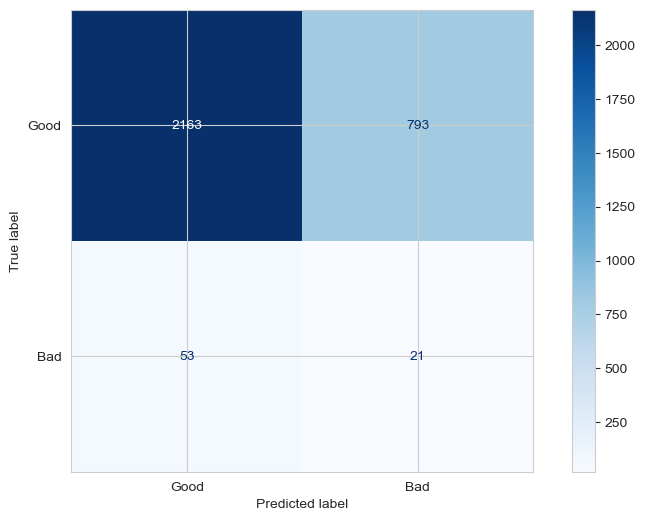

In [ ]:
disp = ConfusionMatrixDisplay.from_estimator(
    model, X_test, y_test,
    display_labels=['Good', 'Bad'],
    cmap='Blues'
)
plt.show()

In [ ]:
# Try differnt thresholds
thresholds = [0.1, 0.2, 0.3, 0.4]

print("Performance at different thresholds:")
for i in thresholds:
    y_pred_thresh = (y_pred_proba >= i).astype(int)
    precision = precision_score(y_test, y_pred_thresh, zero_division=0)
    recall = recall_score(y_test, y_pred_thresh)
    print(f"Threshold {i}: Precision={precision:.3f}, Recall={recall:.3f}")

Performance at different thresholds:
Threshold 0.1: Precision=0.026, Recall=0.878
Threshold 0.2: Precision=0.026, Recall=0.716
Threshold 0.3: Precision=0.030, Recall=0.622
Threshold 0.4: Precision=0.030, Recall=0.473


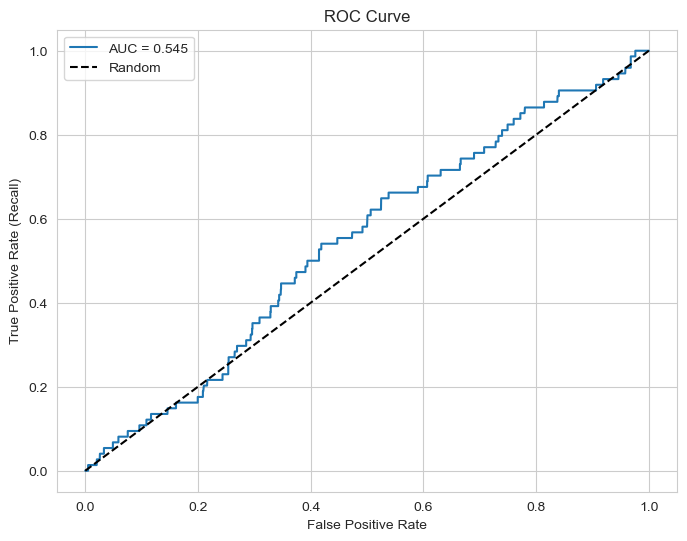

In [ ]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)

# Plot
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'AUC = {auc:.3f}')
plt.plot([0,1], [0,1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [558]:
# Check which features matter
coef_df = pd.DataFrame({
    'feature': X_train.columns,
    'coef': model.coef_[0]
}).sort_values('coef', key=abs, ascending=False)

print("Top 10 features:")
print(coef_df.head(10))

Top 10 features:
              feature  coef
5           has_email -2.49
18      single_parent -1.50
10  housing_municipal -1.28
1        has_property -1.23
13       has_children -1.17
16      is_unemployed -1.06
4           has_phone -0.93
3      has_work_phone -0.76
0             has_car -0.65
6             is_male -0.62


In [561]:
# Quick Random Forest
rf = RandomForestClassifier(
    n_estimators=100,
    random_state=261,
    n_jobs=-1
)

rf.fit(X_train_smote, y_train_smote)

# Evaluate
y_pred_rf = rf.predict_proba(X_test)[:, 1]
auc_rf = roc_auc_score(y_test, y_pred_rf)

print(f"Random Forest AUC: {auc_rf:.3f} vs Logistic AUC: 0.545")

Random Forest AUC: 0.801 vs Logistic AUC: 0.545
